# Word embeddings

## <학습목표>
1. word embeddings의 필요성과 자연어 처리(natural language processing)에서 word embeddings의 사용에 대해서 알아보자.
2. Tensorflow의 word embeddings tutorial의 내용을 숙지하자.
3. skip-gram architecture를 이용하여 word2vec 알고리즘을 구현해보자.

#### 참고자료
- TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)
- A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
- [Distributed Representations of Words and Phrases
and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Mikolov et al.
- [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf) Mikolov et al.
- An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara

## Word embeddings이란?
<img src="../resources/define_embedding.png" width="800">
<img src="../resources/dense_sparse.png" width="800">
영상이나 음성데이터와는 다르게, 언어 데이터를 표현하는 문제는 수십만에서 수백만개의 단어들을 각각 분류해야하는 문제로 치환됩니다. 각 단어들을 one-hot encoding을 하는 경우, 언어 데이터를 표현하는 벡터는 크기가 매우 크지만 매우 sparse한 벡터가 됩니다. one-hot encoding 벡터는 매우 크기때문에 gpu memory에 넣기 힘들며, 한 원소만 1이고 나머지는 다 0으로 저장되는 벡터이기 때문에 매우 비효율적으로 정보를 저장하게 됩니다. 또한 각 단어간에 거리(distance)도 항상 1이 되는 문제점도 있습니다.

word2vec은 이러한 문제점에 착안하여 보다 효율적인 단어의 정보를 표현하는 벡터를 만드는데에 목적을 둔 알고리즘입니다. Vector space models(VSMs)은 continuous한 vector space의 벡터들을 비슷한 문맥상 의미를 가지는 단어들은 서로 가까이하고, 서로 다른 단어는 거리가 멀어지게 학습 하는 것을 목표로 합니다. 예를들면, 검정('black'), 빨강('red'), 파랑('blue')같은 단어들은 서로 가까이 있게되는 것입니다. 이런 식으로 word를 vector로 표현하게되면 Embedding lookup matrix를 학습하게됩니다. 즉 One hot word vector들이 아래와 같은 형식으로 변환되는데, 이는 matrix의 index번째의 row를 가져오는 것과 같기 때문에, embedding lookup matrix(tensor/table/...)라고 합니다.

<img src='../resources/matrix_mult_w_one_hot.png' width=800>

word2vec 알고리즘으로 가장 잘 알려진 알고리즘은 Continuous Bag-of-Words model (CBOW)와 Skip-Gram model이 있습니다.

<img src="../resources/word2vec_archs.png" width="800">

알고리즘의 측면으로만 본다면, 두 모델은 매우 비슷합니다. 위 그림에서 보는 것과 같이 CBOW는 target 단어를 주변 context 단어들을 이용하여 예측하는 반면, Skip-Gram은 CBOW와 반대로 하나의 단어가 주어지고 이 단어를 이용하여 나머지 주변단어들을 예측하도록 학습됩니다. 통계적으로 CBOW는 전체 주변 단어들을 하나의 observation으로 보아서 정답을 예측하기 때문에 예측하는 과정에서 분포적 정보(distributional information)가 smoothing됩니다. 그래서 CBOW는 적은 데이터셋에서 유리합니다. 반면에 skip-gram은 context와 target쌍이 하나의 새로운 observation이 되어서 더 좋은 표현력을 가지게됩니다. 

이번 수업에서는 Skip-gram에 대해서 배워봅니다. 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [2]:
# Tensorflow가 GPU의 모든 memory를 사용하지 않고 dynamic하게 할당하도록 설정합니다.
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [3]:
# 데이터 Download
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + os.path.basename(filename), filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('../data/text8.zip', 31344016)

Found and verified ../data/text8.zip


In [4]:
# 데이터를 string의 list형태로 저장합니다.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size', len(words))

Data size 17005207


In [5]:
# Dictionary를 제작하고 희귀한 단어들은 UNK(Unknown)으로 치환합니다.
vocabulary_size = 50000

def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

# 데이터셋 작성
data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
del words  # 필요없는 변수는 제거하여 메모리를 절약합니다.

In [6]:
# 데이터셋이 잘 만들어 졋는지 확인합니다.
print('Most common words (+UNK)', count[:5])
print('Sample data\n', data[:10])
print([reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data
 [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


Skip-gram batch를 만드는 원리는 아래 그림과 같습니다.
<img src='../resources/skip_gram_batch.png' width=800>
[이미지출처](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

이번 예제에서의 skip_window는 위 그림의 (window 크기-1)/2 입니다.

In [7]:
data_index = 0
# Skip-gram의 학습에 필요한 batch를 만드는 함수를 제작합니다
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels


batch, labels = generate_batch(batch_size=8, num_skips=1, skip_window=2)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

12 as -> 5239 anarchism
6 a -> 12 as
195 term -> 3137 abuse
2 of -> 3137 abuse
3137 abuse -> 59 used
46 first -> 2 of
59 used -> 3137 abuse
156 against -> 46 first


### Softmax Classification
<img src='../resources/skip_gram_net_arch.png' width=800>

## Noise-constrastive estimation (NCE) 
<img src='../resources/noise_classifier.png' width=600>
<img src='../resources/negative_sampling.png' width=600>

In [8]:
# Skip-gram과 모델 코드

batch_size = 128
embedding_size = 128  # embedding vector의 dimension.
skip_window = 1       # 왼쪽, 오른쪽의 skip_window의 크기
num_skips = 2         # 동일한 input에 대해 얼마만큼의 output을 할당 할 것인지

# 임의의 validation set을 nearest neighbor를 sample하기위해 만듭니다.  
# validation samples은 빈도수가 높은 단어를 위주로 뽑습니다.
valid_size = 16     # Similarity를 계산하기위한  Val set의 크기
valid_window = 100  # 빈도가 가장 높은 valid_window순 까지의 벡터를 고릅니다.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # negative sample의 수.

graph = tf.Graph()

with graph.as_default():
    # Input data의 placeholder를 설정.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # GPU에 변수들을 넣습니다. 일반적으로 default가 /gpu:0로 되어있어서 다른 GPU에 넣고 싶을 경우 따로 지정해야합니다.
    with tf.device('/gpu:0'):
        # input data의 Look up embeddings.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # NCE loss 계산을 위한 variables
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # 각 batch의 Average NCE loss
    # tf.nce_loss 함수는 새로운 negative label을 sample하여 loss를 계산합니다.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_labels,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))

    # SGD optimizer, a learning rate 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # minibatch 샘플들과 and 모든 embeddings과의 cosine similarity를 계산합니다. 
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

In [9]:
# 학습
num_steps = 100001

with tf.Session(graph=graph, config=config) as session:
    # 모든 변수들을 초기화 합니다.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        # batch를 가져옵니다
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000
            # batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500
        # steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  265.243286133
Nearest to on: competitive, parliamentarian, west, inlet, illicit, tora, sinfonia, prevent,
Nearest to was: throughput, bipedalism, developmental, cordell, votes, armand, merger, ibadi,
Nearest to united: rematch, aggressor, netting, kaliningrad, purgatory, plain, shambhala, bin,
Nearest to at: occured, waterloo, sequential, certain, delineation, disable, graf, ejaculation,
Nearest to war: ordination, mayors, teased, dagda, dimensions, squarepants, conjure, kapital,
Nearest to of: onslaught, stimulate, greene, nightly, revived, yuri, help, randell,
Nearest to first: selma, workflow, vukovar, ruben, quarantine, burger, ricky, toolkit,
Nearest to these: zion, aspirated, snegur, permeable, staffs, abandoning, scrub, ubiquitous,
Nearest to history: nicholas, harmonising, custis, westernmost, entertain, ingesting, compensate, arid,
Nearest to seven: conspirators, aitken, denunciation, privacy, http, coltrane, liaisons, tel,
Nearest to tha

In [10]:
# embedding 시각화.

def plot_with_labels(low_dim_embs, labels, filename='results/tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    if not os.path.isdir(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    plt.savefig(filename)

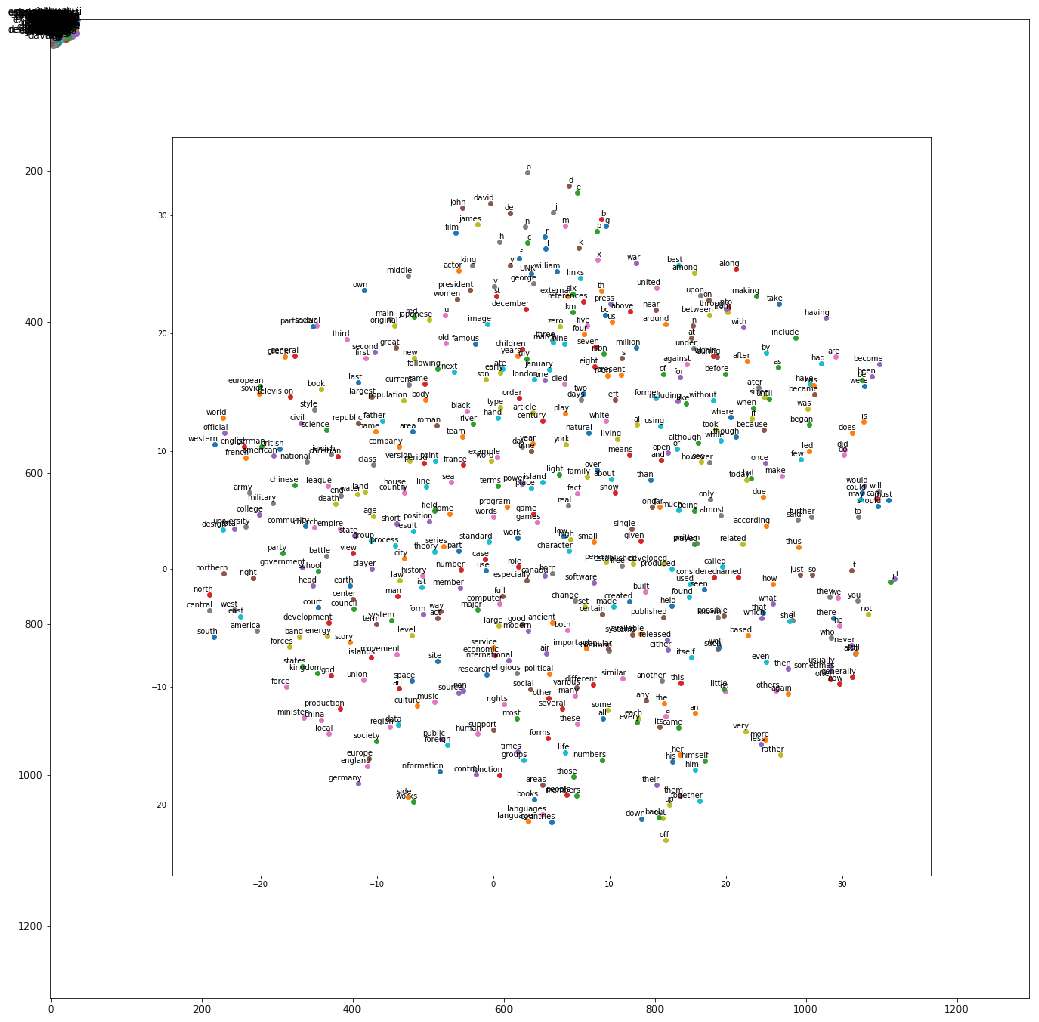

In [11]:
try:
    from sklearn.manifold import TSNE
    from PIL import Image
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    filename='results/tsne.png'
    plot_with_labels(low_dim_embs, labels, filename)
    I=Image.open(filename)
    plt.imshow(I)
    plt.show()
except ImportError:
    print("Please install sklearn, matplotlib, pillow, and scipy to visualize embeddings.")